# Imports

In [1]:
import tensorflow as tf 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Declare global variables and hyperparameters

In [2]:
window_size = 132 # In months
# If you are running this on a google colab or not sure where to put the target data just use "/tmp/" (1st command otherwise the second)
data_path = "/tmp/"
# data_path = "/Users/neeraj/Personal/learn/github/tensorflowPlayground/coursera/course4_time_series/week4/Data/"
csv_file_name = "Sunspots.csv"
csv_file_path = os.path.join(data_path, csv_file_name)
batch_size = 128
shuffle_buffer = 1000
train_data_size = 3000

# Get data


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O $csv_file_path

--2021-06-05 11:34:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/Sunspots.csv’

/tmp/Sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-06-05 11:34:13 (77.4 MB/s) - ‘/tmp/Sunspots.csv’ saved [70827/70827]



## Explore data

In [4]:
df = pd.read_csv(csv_file_path, index_col=0)
print("Shape of the data : ", df.shape)

Shape of the data :  (3235, 2)


In [5]:
df.columns

Index(['Date', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [6]:
df[:5]

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [7]:
df[-5:]

,Date,Monthly Mean Total Sunspot Number
3230,2018-03-31,2.5
3231,2018-04-30,8.9
3232,2018-05-31,13.2
3233,2018-06-30,15.9
3234,2018-07-31,1.6


Checking for missing data points

In [8]:
3235 == (2018 - 1749)*12 + 7

True

From initial inspection what we can see is that we have data of 3235 months with no missing datapoints from `1749-01-31` to `2018-07-31` every month's mean total sunspot 

# Preprocessing of the data

In [9]:
df.columns = ["Date", "Mean_sun_spot"]

In [10]:
df[:5]

,Date,Mean_sun_spot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


# Visualisation of data

In [44]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (in months)")
    plt.ylabel("Value")
    plt.grid(True)

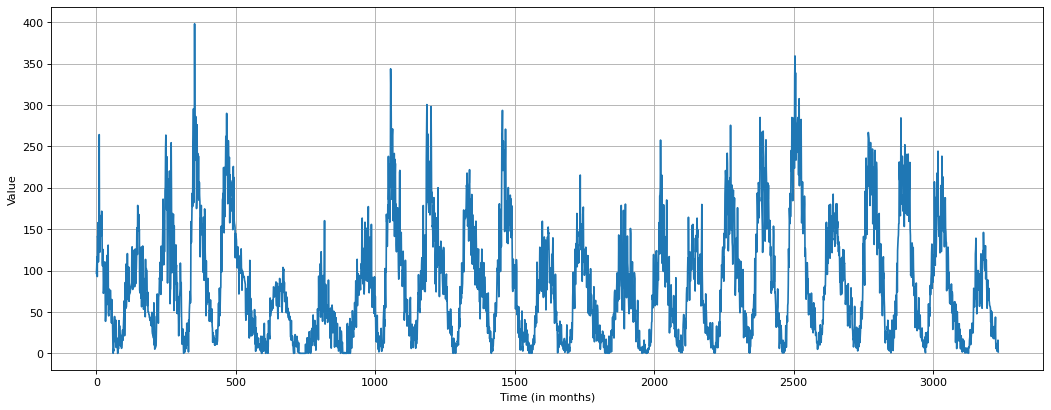

In [45]:
figure(figsize=(16, 6), dpi=80)
plot_series(df.index.values, df["Mean_sun_spot"])

# Seasonality in data

A very naive approach will tell us that there are `24.5 peaks` over a period of `3235` months

So we can say roughly that the seasonality in data is `132 months`

# Window data function

In [13]:
def generate_window_data_for_train(series, window_size, batch_size, shuffle_buffer):
    # Below command is required as Conv1D requires a 3D input => batch_shape + (steps, input_dim). Here steps will be the window size and 
    # we are just using one feature i.e Mean_sun_spot so the input_dim will be just 1
    series = tf.expand_dims(series, axis=-1) 
    dataset = tf.data.Dataset.from_tensor_slices(series) # Converting to tensors
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda x: (x[:-1], x[-1]))
    return dataset.batch(batch_size).prefetch(1)

In [14]:
def generate_window_data_for_test(series, window_size, batch_size, shuffle_buffer):
    # Below command is required as Conv1D requires a 3D input => batch_shape + (steps, input_dim). Here steps will be the window size and 
    # we are just using one feature i.e Mean_sun_spot so the input_dim will be just 1
    series = tf.expand_dims(series, axis=-1) 
    dataset = tf.data.Dataset.from_tensor_slices(series) # Converting to tensors
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    return dataset.batch(batch_size).prefetch(1)

# Make train and test data

In [42]:
train_x = df["Mean_sun_spot"][:train_data_size]
train_time = df.index.values[:train_data_size]
val_x = df["Mean_sun_spot"][train_data_size:]
val_time = df.index.values[train_data_size:]

In [16]:
train_data = generate_window_data_for_train(train_x, window_size, batch_size, shuffle_buffer)

Inspecting each element of the generated data to check if the `X` and `Y` has the right dimensions

In [17]:
for i in train_data.as_numpy_iterator():
  print("Output should be 2 :: ", len(i)) 
  print("Output should be ({}, {}, {}) :: ".format(batch_size, window_size, 1), i[0].shape)
  print("Output should be ({}, {}) :: ".format(batch_size, 1), i[1].shape)
  break

Output should be 2 ::  2
Output should be (128, 132, 1) ::  (128, 132, 1)
Output should be (128, 1) ::  (128, 1)


# Define model

## Hyper parameter tuning (learning rate)

In [18]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv1D(32, 5, activation="relu", input_shape=[window_size, 1], padding="causal", strides=1),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.LSTM(64, return_sequences=True), # There is no need to do `return_sequences=True` you can make that parameter False as well 
                            #  but this will make sure that each datapoint in the window will have have more influence on the output, i thik (:-p)
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dense(16, activation="relu"),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x * 400) # As max sunspot data is 398.2, we can either normalize the data or scale the output like this 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 132, 32)           192       
_________________________________________________________________
lstm (LSTM)                  (None, 132, 64)           24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 132, 64)           33024     
_________________________________________________________________
dense (Dense)                (None, 132, 32)           2080      
_________________________________________________________________
dense_1 (Dense)              (None, 132, 16)           528       
_________________________________________________________________
dense_2 (Dense)              (None, 132, 1)            17        
_________________________________________________________________
lambda (Lambda)              (None, 132, 1)            0

### Define lerning rate scheduler

In [19]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 **(epoch/20)
)

In [21]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9), metrics=["mae"])
history = model.fit(train_data, epochs=100, callbacks=[lr_scheduler_callback])

Epoch 1/100
23/23 [==============================] - 4s 31ms/step - loss: 47.1771 - mae: 47.6750
Epoch 2/100
23/23 [==============================] - 1s 34ms/step - loss: 47.1156 - mae: 47.6135
Epoch 3/100
23/23 [==============================] - 1s 34ms/step - loss: 47.0440 - mae: 47.5419
Epoch 4/100
23/23 [==============================] - 1s 34ms/step - loss: 46.9614 - mae: 47.4592
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 46.8785 - mae: 47.3763
Epoch 6/100
23/23 [==============================] - 1s 33ms/step - loss: 46.7876 - mae: 47.2854
Epoch 7/100
23/23 [==============================] - 1s 33ms/step - loss: 46.6935 - mae: 47.1914
Epoch 8/100
23/23 [==============================] - 1s 33ms/step - loss: 46.5947 - mae: 47.0925
Epoch 9/100
23/23 [==============================] - 1s 34ms/step - loss: 46.4942 - mae: 46.9919
Epoch 10/100
23/23 [==============================] - 1s 33ms/step - loss: 46.3912 - mae: 46.8887
Epoch 11/100
23/23 [=========

### Monitoring loss across learning rate to find best possible lerning rate 

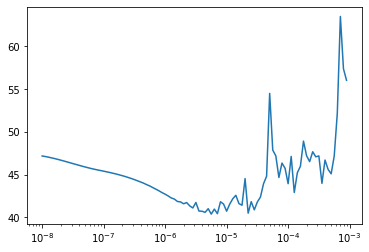

In [26]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.show()

**Norrowing our focus on the band that shows promising results**

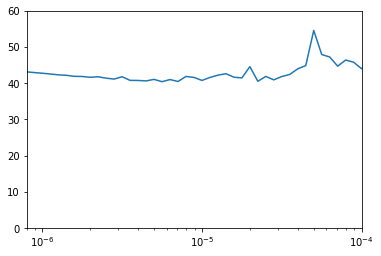

In [29]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([8e-7, 1e-4, 0, 60])
plt.show()

**Promising Learining rate : 1e-5**

## Rewriting the model

In [53]:
# Rewriting these variables only to for ease of changing it continiously to improve the model
window_size = 62
batch_size = 128
train_data = generate_window_data_for_train(train_x, window_size, batch_size, shuffle_buffer)

In [61]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv1D(64, 5, activation="relu", input_shape=[window_size, 1], padding="causal", strides=1),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.LSTM(64, return_sequences=True), # There is no need to do `return_sequences=True` you can make that parameter False as well 
                            #  but this will make sure that each datapoint in the window will have have more influence on the output, i thik (:-p)
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dense(16, activation="relu"),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x * 400) # As max sunspot data is 398.2, we can either normalize the data or scale the output like this 
])

model.summary()

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(train_data, epochs=400)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 62, 64)            384       
_________________________________________________________________
lstm_8 (LSTM)                (None, 62, 64)            33024     
_________________________________________________________________
lstm_9 (LSTM)                (None, 62, 64)            33024     
_________________________________________________________________
dense_12 (Dense)             (None, 62, 32)            2080      
_________________________________________________________________
dense_13 (Dense)             (None, 62, 16)            528       
_________________________________________________________________
dense_14 (Dense)             (None, 62, 1)             17        
_________________________________________________________________
lambda_4 (Lambda)            (None, 62, 1)            

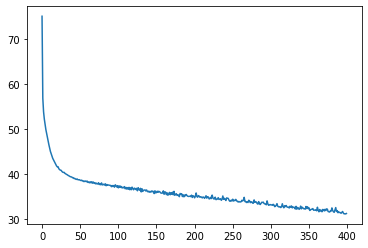

In [62]:
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.show()

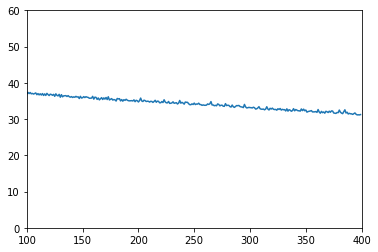

In [63]:
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.axis([100, 400, 0, 60])
plt.show()

In [64]:
series = df[train_data_size-window_size:]["Mean_sun_spot"]
test_data = generate_window_data_for_test(series, window_size, batch_size, shuffle_buffer)
pred_layer_output = model.predict(test_data)

### Get predictions

As we used `return_sequences=True` in our RNN layer, LSTM, we will the dimensionality of the output is now (batch_size, window_size, 1) instead of (batch_size, 1) so we will take only the last element of the each window as in a sequential data we generally take the output of the last element. 

In [65]:
test_preds = pred_layer_output[:, -1, 0]

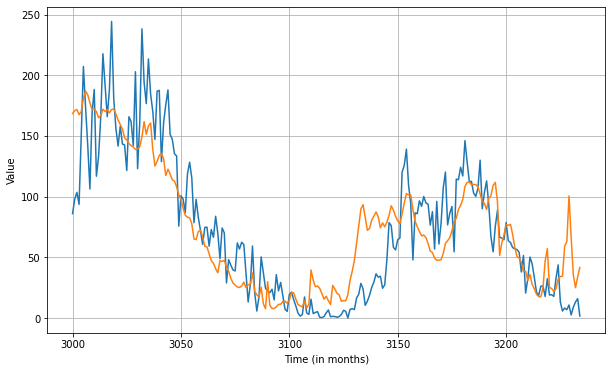

In [66]:
plt.figure(figsize=(10, 6))
plot_series(val_time, val_x)
plot_series(val_time, test_preds)

In [67]:
tf.keras.metrics.mean_absolute_error(val_x, test_preds).numpy()

23.81358